# 02. PyTorch Neural Network Classification

Classification is the problem of predicting whether something is one thing or another.

Different types of `classifications`:
1. `Binary Classification`
   - yes/no
   - spam/not spam
3. `Multi-class Classification`
   - dog, cat, or chicken
5. `Multi-label Classification`
   - single input multiple outputs(hen,dog/cat,hen)

## Classification Inputs and Outputs
![](images/classification_input_output.png)

Shape of input: `[batch_size, color_chalnnels, width, height]` - images

eg: `[None,2,224,224]` or `[32,2,224,224]`

Shape of output: `depends on number of classes`

if we have 3 classes then shape is [3]

## Architecture of a classfication model (WIP)

## Circle Classification

### 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X,y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
import pandas as pd

In [5]:
data = pd.DataFrame({
    'X1': X[:,0],
    'X2': X[:,1],
    'label': y
})
data.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [6]:
import matplotlib.pyplot as plt

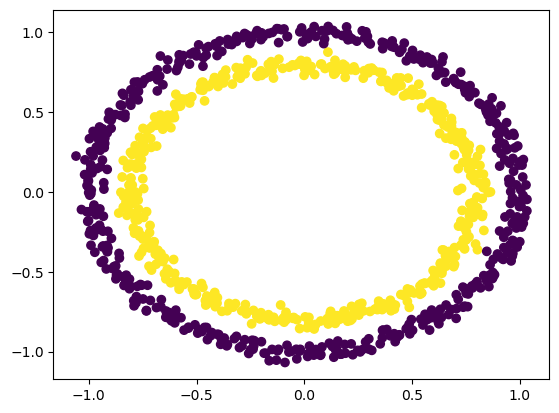

In [7]:
plt.scatter(X[:,0], X[:,1], c=y, label='Circles');

#### 1.1. Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

X has `2` features/columns, `1000` observations

y has just `1` column - doesnt have a shape, `1000` observations

In [9]:
# view the shape of one data 

X_sample = X[0]
y_sample = y[0]

print(f"Values of the sample data: X: {X_sample} y: {y_sample}")
print(f"Shapes of the sample data: X: {X_sample.shape} y: {y_sample.shape}")

Values of the sample data: X: [0.75424625 0.23148074] y: 1
Shapes of the sample data: X: (2,) y: ()


Baseline

In [10]:
baseline = data['label'].value_counts(normalize=True).max()
print('Baseline Accuracy is: ', baseline)

Baseline Accuracy is:  0.5


#### 1.2. Turn data into Tensors
and create train and test splits

In [11]:
import torch
torch.__version__

'2.0.1'

In [12]:
type(X)

numpy.ndarray

In [13]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [14]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [15]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [16]:
# split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 2. Make Model

Let's build a model to classify our circle dots.

To do so, we want to:
1. Setup `device agnostic code` so that our code can run on `GPU` if available.
2. Construct a `model` (by subclassing `nn.Module`)
3. Define `loss` function and an `optimizer`
4. Create a `training and test loop`

In [18]:
# import pytorch and nn
import torch
from torch import nn

# 1. make device agnostic mode
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#### 1. Constructing a model

Let's create a model that:
1. Subclass `nn.Module`
2. creates 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass of the model
4. Intantiate an instance of our model class and send it to the target `device`

In [19]:
X.shape

torch.Size([1000, 2])

In [20]:
class CircleModuleVO(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features = 5, out_features=1)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer2(self.layer1(x))

# instantiate and put it into the target device
model_0 = CircleModuleVO()
model_0.to(device)

CircleModuleVO(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
# replicate the above model using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4791,  0.5318],
                      [ 0.5891,  0.5217],
                      [-0.5647, -0.3750],
                      [-0.2930,  0.1931],
                      [ 0.2613,  0.3142]])),
             ('0.bias', tensor([ 0.4537,  0.1836, -0.1225, -0.6365, -0.2417])),
             ('1.weight',
              tensor([[ 0.0787,  0.2373, -0.2820, -0.3792,  0.1930]])),
             ('1.bias', tensor([-0.2461]))])

In [23]:
# make initial predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(untrained_preds[:10], untrained_preds.shape)

print(f'orig labels: {y_test[:10]}')

tensor([[ 0.0804],
        [ 0.3173],
        [-0.3163],
        [ 0.1919],
        [ 0.0400],
        [ 0.1819],
        [ 0.5667],
        [ 0.5359],
        [-0.3307],
        [ 0.3372]]) torch.Size([200, 1])
orig labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


#### 2. Setup loss function and optimizer
`loss_fn = ...`

loss function measures how wrong our model's predictions are.

this can be different from different problems. for ex. regression - MSE, MAE etc, classification binary cross entropy, categorical cross entropy


`optimizer = ...`


In [24]:
# binary cross entropy (BCE)
# sigmoid + BCELOSS() exits but BCEwithLogitsLoss() is better bc it combines
# the operation in 1 layer and we take advantage of the log-sum-exp trick for numerical stability
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

In [25]:
# calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100

    return acc

#### 3. Training a model
To train our model, we are going to build a training loop with the following steps:
1. Forward pass
2. Calculate the loss
3. Optimizer Zero grad
4. loss backward (backpropagation)
5. Optimizer Step (Gradient Descent)

**3.1 Going from raw logits -> prediction probabilities -> prediction labels**

- Our Model outputs are going to be a raw **logits**
  
- We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation functions (e.g. `sigmoid for binary classification` and `softmax` for `multiclass classification`).
  
- Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`


In [26]:
# View the first 5 outputs of the forward pass on the test data

model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test[:5].to(device))
y_logits

tensor([[ 0.0804],
        [ 0.3173],
        [-0.3163],
        [ 0.1919],
        [ 0.0400]])

These are `logits`, 

we have to `pass` it to an `activation function` to get the `prediction probabilities`.

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [28]:
# use the sigmoid activation function on our model logits to turn to the prediction probabilities
y_pre_proba = torch.sigmoid(y_logits)
y_pre_proba

tensor([[0.5201],
        [0.5787],
        [0.4216],
        [0.5478],
        [0.5100]])

For our prediction probabilitiies values, we need to performa a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y=1`
* `y_pred_probs` < 0.5, `y=0`


In [29]:
y_preds = torch.round(y_pre_proba)

# full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test)))
y_pred_labels[:5]

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.]], grad_fn=<SliceBackward0>)

In [30]:
# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels[:5].squeeze()))

tensor([True, True, True, True, True])


**3.2 Building Training and Testing Loop**

In [31]:
#random seed
torch.manual_seed(42)

EPOCHS = 100

for epoch in range(EPOCHS):
    # training loop
    model_0.train()

    # forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))# logits -> pred proba -> labels

    # loss/accuracy and optimizer
    # BCELoss expects pred_proba 
    # BCEWithLogitsLoss expects logits
    loss = loss_fn(y_logits, y_train) # BCEWithLogits expects logits not y_pred
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    
    optimizer.zero_grad()
    loss.backward() # backpropagattion
    optimizer.step()

    #testing loop
    model_0.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out what's happening
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}')
    

Epoch: 0 | Loss: 0.70352, Acc: 50.75 | Test Loss: 0.71629, Test Acc: 47.00
Epoch: 10 | Loss: 0.70052, Acc: 51.25 | Test Loss: 0.71152, Test Acc: 47.50
Epoch: 20 | Loss: 0.69855, Acc: 50.50 | Test Loss: 0.70815, Test Acc: 47.50
Epoch: 30 | Loss: 0.69716, Acc: 50.50 | Test Loss: 0.70564, Test Acc: 47.50
Epoch: 40 | Loss: 0.69616, Acc: 50.38 | Test Loss: 0.70371, Test Acc: 47.00
Epoch: 50 | Loss: 0.69542, Acc: 50.38 | Test Loss: 0.70218, Test Acc: 47.50
Epoch: 60 | Loss: 0.69486, Acc: 50.25 | Test Loss: 0.70096, Test Acc: 47.50
Epoch: 70 | Loss: 0.69443, Acc: 50.38 | Test Loss: 0.69997, Test Acc: 47.50
Epoch: 80 | Loss: 0.69411, Acc: 50.50 | Test Loss: 0.69916, Test Acc: 48.00
Epoch: 90 | Loss: 0.69386, Acc: 50.38 | Test Loss: 0.69848, Test Acc: 48.00


From the metrics, it looks like our model isn't learning anything...

So, to inspect it, let's make some predictions and make them visual.

In other words, `visualize, visualize, visualize!!`

In [32]:
import sys
sys.path.append('..')

from helper_functions import plot_decision_boundary, plot_predictions

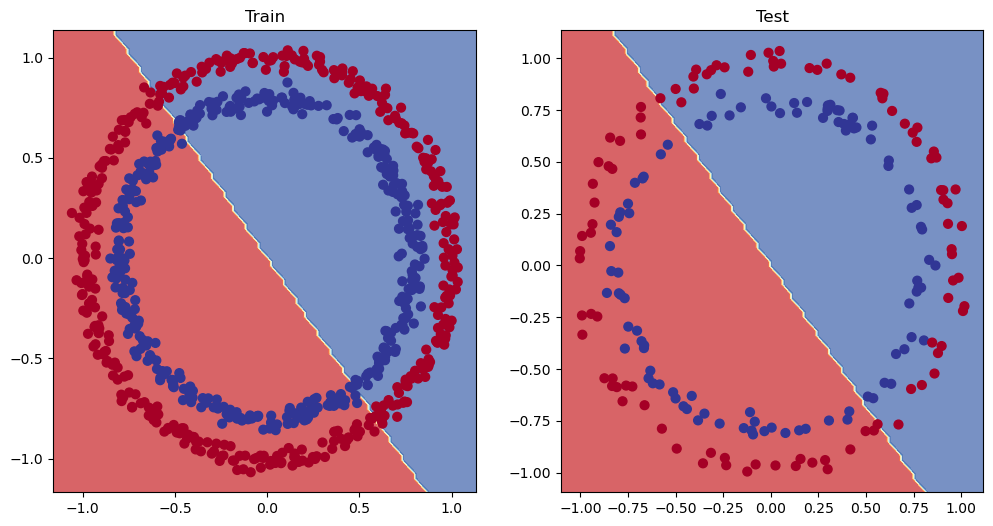

In [33]:
# plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

In [34]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5005,  0.5221],
                      [ 0.5571,  0.5068],
                      [-0.5202, -0.3546],
                      [-0.2157,  0.2282],
                      [ 0.2273,  0.2986]])),
             ('0.bias', tensor([ 0.4523,  0.1797, -0.1178, -0.6300, -0.2450])),
             ('1.weight',
              tensor([[ 0.1258,  0.0570, -0.1243, -0.3329,  0.1131]])),
             ('1.bias', tensor([-0.2639]))])

**Improving a model (from a model perspective)** 

* Add more layers - give the model more chances to learn about pattern in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Chaning the activation functions
* change the learning rate (Exploding and vanishing gradient descent problem)
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

and because these optiona re all values we (as machine learning engineers) can change, they are refered to as **hyperpatameters**

Let's try and improve our model by:
* adding more hidden units: 5-> 10
* increate the number of layers: 2 ->3
* increase the number of epochs: 100 -> 1000

In [35]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_1 = nn.Linear(in_features=2, out_features=10)
        self.linear_layer_2 = nn.Linear(in_features=10, out_features=10)
        self.linear_layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_3(self.linear_layer_2(self.linear_layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1
         

CircleModelV1(
  (linear_layer_1): Linear(in_features=2, out_features=10, bias=True)
  (linear_layer_2): Linear(in_features=10, out_features=10, bias=True)
  (linear_layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
model_1.state_dict()

OrderedDict([('linear_layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('linear_layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('linear_layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  

In [37]:
# loss and optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [38]:
torch.manual_seed(42)
# traning amodel
epochs = 1000

for epoch in range(epochs):
    # training loop
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #testing loop
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}"
        )

Epoch: 0 | Loss: 0.69396, Acc: 50.88 | Test Loss: 0.69261, Test Acc: 51.00
Epoch: 10 | Loss: 0.69392, Acc: 50.50 | Test Loss: 0.69262, Test Acc: 51.00
Epoch: 20 | Loss: 0.69389, Acc: 50.62 | Test Loss: 0.69262, Test Acc: 50.50
Epoch: 30 | Loss: 0.69386, Acc: 50.62 | Test Loss: 0.69263, Test Acc: 50.50
Epoch: 40 | Loss: 0.69383, Acc: 50.62 | Test Loss: 0.69264, Test Acc: 50.50
Epoch: 50 | Loss: 0.69381, Acc: 50.75 | Test Loss: 0.69264, Test Acc: 50.50
Epoch: 60 | Loss: 0.69378, Acc: 50.62 | Test Loss: 0.69265, Test Acc: 51.00
Epoch: 70 | Loss: 0.69376, Acc: 50.25 | Test Loss: 0.69266, Test Acc: 51.00
Epoch: 80 | Loss: 0.69373, Acc: 50.00 | Test Loss: 0.69267, Test Acc: 50.50
Epoch: 90 | Loss: 0.69371, Acc: 49.88 | Test Loss: 0.69268, Test Acc: 50.50
Epoch: 100 | Loss: 0.69369, Acc: 50.25 | Test Loss: 0.69269, Test Acc: 50.00
Epoch: 110 | Loss: 0.69367, Acc: 50.25 | Test Loss: 0.69270, Test Acc: 50.00
Epoch: 120 | Loss: 0.69365, Acc: 50.38 | Test Loss: 0.69272, Test Acc: 50.00
Epoch: 130

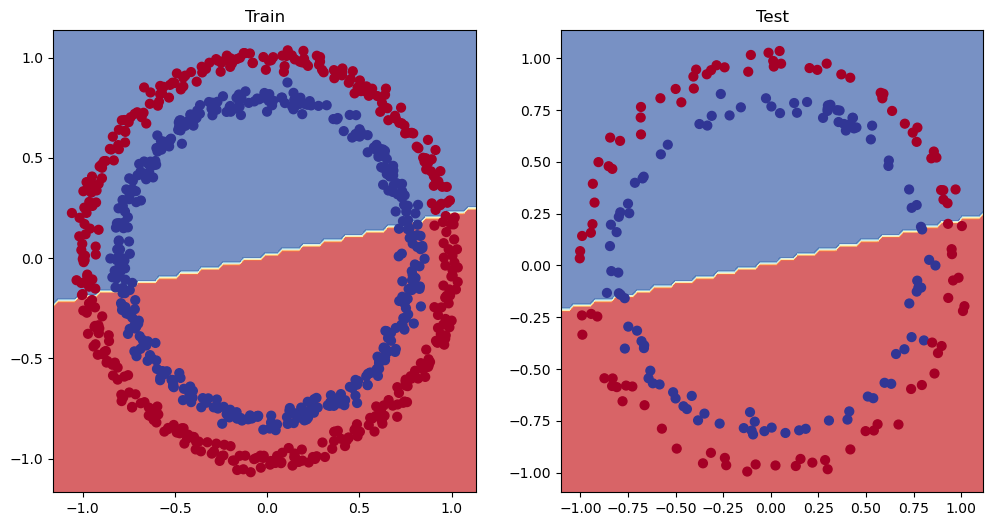

In [39]:
# plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

## Checking if our model can fit straight line

### Preparing data

In [40]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [41]:
# Create train and test splits
cutoff = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:cutoff], y_regression[:cutoff]
X_test_regression, y_test_regression = X_regression[cutoff:], y_regression[cutoff:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20



Beautiful, let's see how the data looks.

To do so, we'll use the plot_predictions() function we created in notebook 01.

It's contained within the helper_functions.py script on the Learn PyTorch for Deep Learning repo which we downloaded above.

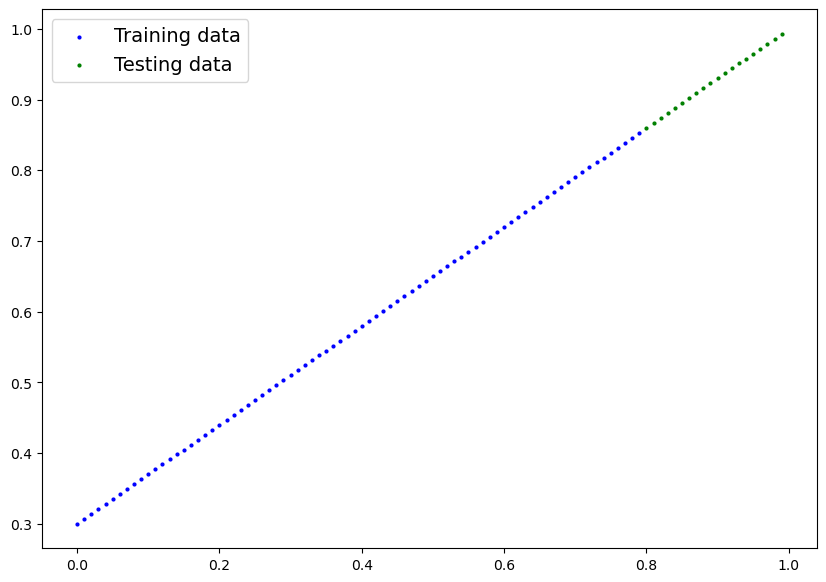

In [42]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [43]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [45]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603



Okay, unlike model_1 on the classification data, it looks like model_2's loss is actually going down.

Let's plot its predictions to see if that's so.

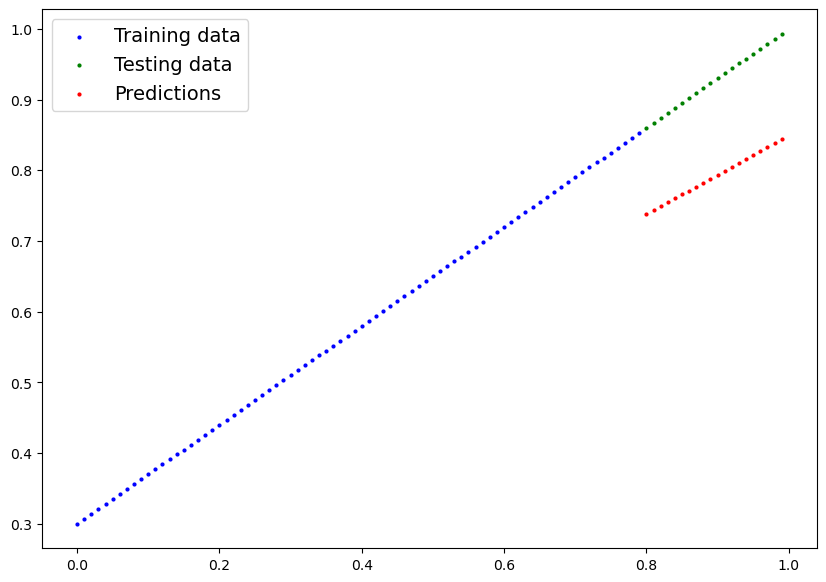

In [46]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());


Alright, it looks like our model is able to do far better than random guessing on straight lines.

This is a good thing.

It means our model at least has some capacity to learn.

> **Note**: A helpful troubleshooting step when building deep learning models is to start as small as possible to see if the model works before scaling it up.
>
> This could mean starting with a simple neural network (not many layers, not many hidden neurons) and a small dataset (like the one we've made) and then `overfitting` (making the model perform too well) on that small example before increasing the amount data or the model size/design to reduce overfitting.

So what could it be?



>
> **The Answer is Non-Linear**

## Building a model with non-linearity

* Linear - straight line
* Non-Linear - non straight line

In [47]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_1 = nn.Linear(in_features=2, out_features=10)
        self.linear_layer_2 = nn.Linear(in_features=10, out_features=10)
        self.linear_layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return (
            self.linear_layer_3(
                self.relu(
                    self.linear_layer_2(
                         self.relu(
                            self.linear_layer_1(x)
                        )
                    )
                )
            )
        )
       

model_3 = CircleModelV2().to(device)
model_3
         

CircleModelV2(
  (linear_layer_1): Linear(in_features=2, out_features=10, bias=True)
  (linear_layer_2): Linear(in_features=10, out_features=10, bias=True)
  (linear_layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [48]:
# setup loss and an optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    params=model_3.parameters(),
    lr=0.1
)

In [49]:
# train model
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    #training loop
    model_3.train()

    #forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred = y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #testing loop
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred = test_pred)

    if epoch % 10 == 0 :
        print(
            f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}'
        )

Epoch: 0 | Loss: 0.69295, Acc: 50.00 | Test Loss: 0.69319, Test Acc: 50.00
Epoch: 10 | Loss: 0.69248, Acc: 50.50 | Test Loss: 0.69260, Test Acc: 50.00
Epoch: 20 | Loss: 0.69225, Acc: 59.13 | Test Loss: 0.69231, Test Acc: 56.50
Epoch: 30 | Loss: 0.69209, Acc: 70.25 | Test Loss: 0.69212, Test Acc: 68.00
Epoch: 40 | Loss: 0.69195, Acc: 68.38 | Test Loss: 0.69195, Test Acc: 71.00
Epoch: 50 | Loss: 0.69181, Acc: 58.25 | Test Loss: 0.69177, Test Acc: 58.00
Epoch: 60 | Loss: 0.69168, Acc: 54.00 | Test Loss: 0.69161, Test Acc: 54.50
Epoch: 70 | Loss: 0.69155, Acc: 53.12 | Test Loss: 0.69146, Test Acc: 53.00
Epoch: 80 | Loss: 0.69141, Acc: 52.62 | Test Loss: 0.69132, Test Acc: 53.00
Epoch: 90 | Loss: 0.69128, Acc: 52.75 | Test Loss: 0.69117, Test Acc: 53.00
Epoch: 100 | Loss: 0.69115, Acc: 52.88 | Test Loss: 0.69102, Test Acc: 52.50
Epoch: 110 | Loss: 0.69103, Acc: 52.88 | Test Loss: 0.69088, Test Acc: 53.50
Epoch: 120 | Loss: 0.69090, Acc: 53.12 | Test Loss: 0.69074, Test Acc: 54.00
Epoch: 130

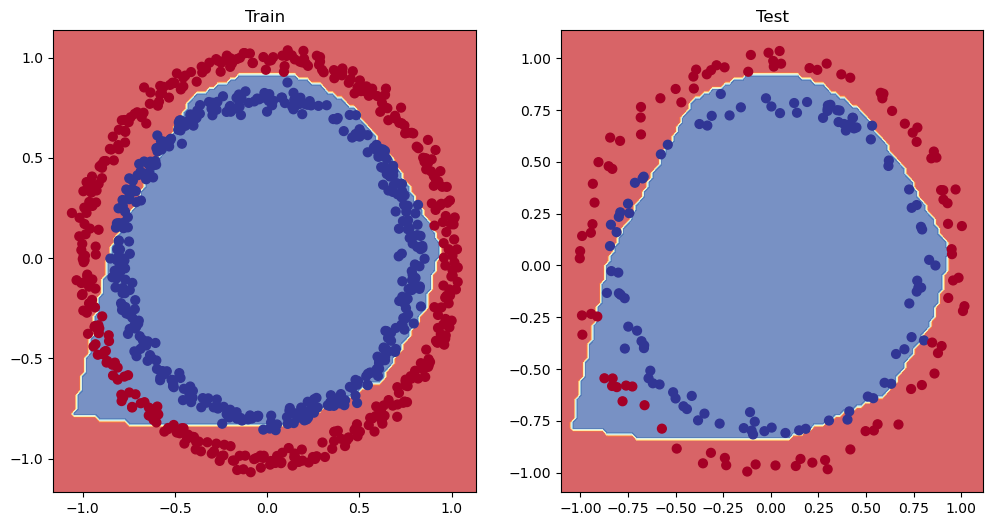

In [50]:
# plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

### Evaluating the model trained on non-linear activation function

In [51]:
model_3.eval()
with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(test_logits))
y_test_pred[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### Replicating Non Linear Activation Functions

Neural network is a large stack of `linear` and `non-linear` functions

In [52]:
A = torch.arange(-10,10,1, dtype=torch.float64)
A.dtype

torch.float64

In [53]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.], dtype=torch.float64)

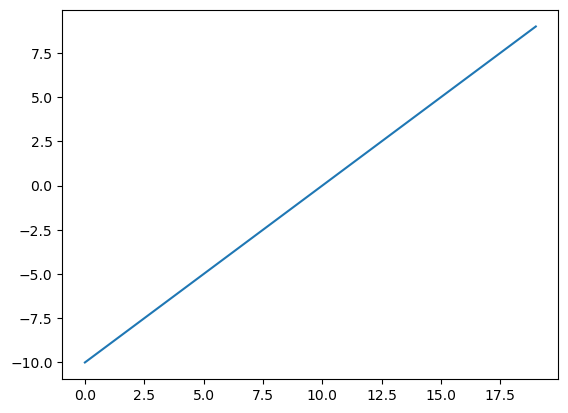

In [54]:
plt.plot(A)

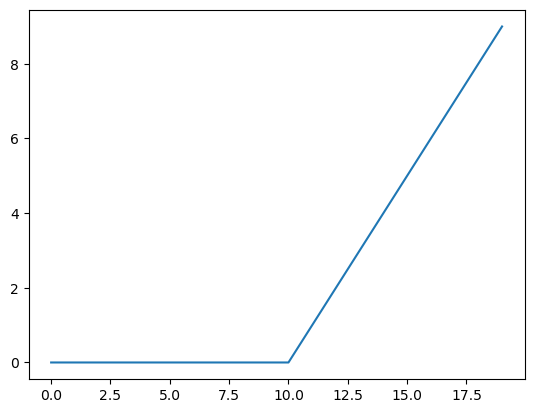

In [55]:
# plotting the built in relu function
plt.plot(torch.relu(A))

In [56]:
# creating our own relu function
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

In [57]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.], dtype=torch.float64)

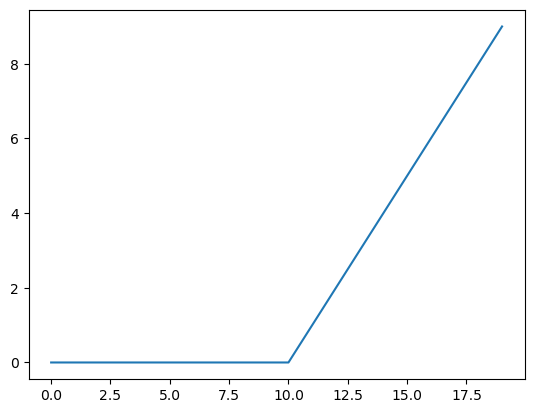

In [58]:
# plotting our custom relu function
plt.plot(relu(A))

**Sigmoid function**

In [59]:
def sigmoid(x:torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

In [60]:
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01], dtype=torch.float64)

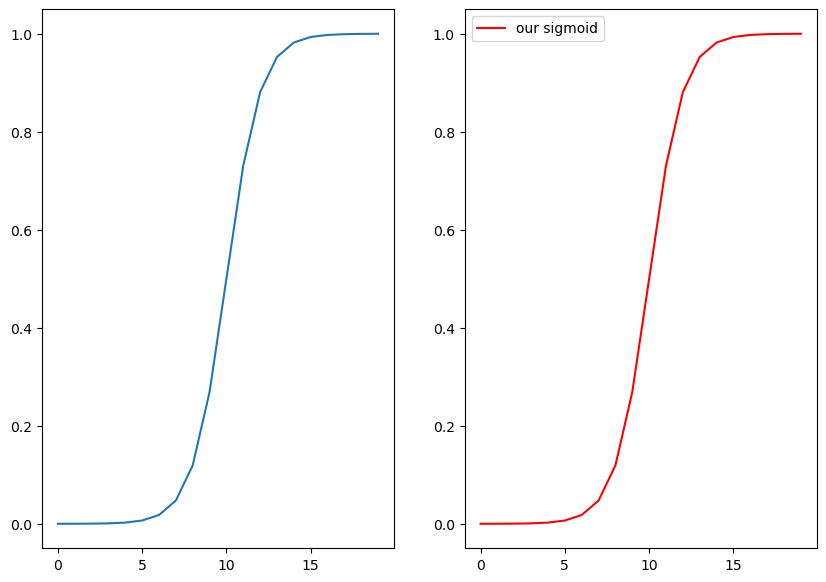

In [61]:
# plotting pytorch sigmoid and our sigmoid

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.plot(torch.sigmoid(A), label='pytorch sigmoid')
plt.subplot(1,2,2)
plt.plot(sigmoid(A), label='our sigmoid', c='r')
plt.legend();

## 8. Putting it all together with a multi-class classification
* Binary Classification
  - one thing or another (cat vs dog, spam vs non spam)
* Multi-class Classification
  - more than one thing or another (cat vs dog vs chicken)

### 8.1. Creating a toy multi-class dataset

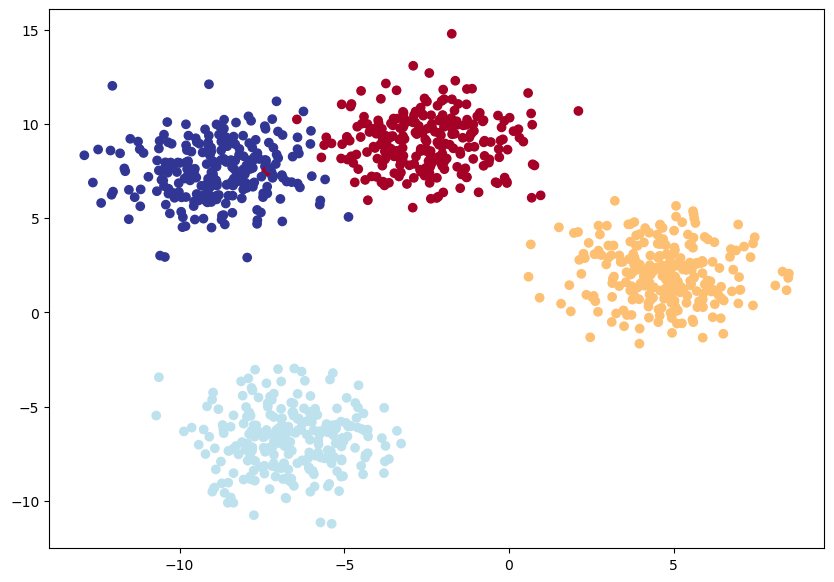

In [62]:
# import dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets  import make_blobs

# set the values of the hyperparameters for the data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=2,
                            centers=4,
                            cluster_std=1.5,
                            random_state=42)
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                        y_blob, 
                                                                        test_size=0.2, 
                                                                        random_state=RANDOM_SEED)
# 4. Plot data (Visualize, Visualize, Visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:, 1], c = y_blob, cmap=plt.cm.RdYlBu)

In [63]:
print(X_blob[:5])
print(X_blob[:,0][:5])
print(X_blob[:,1][:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]])
tensor([-8.4134, -5.7665, -6.0421,  3.9508,  4.2505])
tensor([ 6.9352, -6.4312, -6.7661,  0.6984, -0.2815])


### 8.2. Building a multi-class classification in PyTorch

In [64]:
# create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [65]:
# Build a multi-class classification model

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes the multi-class blob classification model
    
        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features (number of output classes)
            hidden_units (int): Number of hidden units between layers, default 8
    
        Returns:
    
        Example:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU()
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU()
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)

# lets create the instance of the blob model and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

"

In order to evaluate, train, and test our models, we need to convert our model's output (logits) to prediction labels

logits (raw output of the model) `->` Pred Probs (use torch.softmax) `->` Pred labels take the argmax of the pred probs

In [66]:
X_blob_train.dtype

torch.float32

In [67]:
# let's get some raw outputs of our model (logits)
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
print(y_preds[:10])

y_preds_prob = torch.softmax(y_logits, dim=1)[:10]
print(y_preds_prob)

y_preds = torch.argmax(y_preds_prob, dim=1)
print(f'pred: {y_preds[:10]}')

print(f'real: {y_train[:10]}')

tensor([[0.7379],
        [0.7434],
        [0.7490],
        [0.7546],
        [0.7602],
        [0.7657],
        [0.7713],
        [0.7769],
        [0.7825],
        [0.7880]])
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951],
        [0.2788, 0.0088, 0.2893, 0.4232],
        [0.3246, 0.1261, 0.4545, 0.0948],
        [0.2229, 0.0443, 0.1867, 0.5461],
        [0.3447, 0.0368, 0.5269, 0.0917],
        [0.2145, 0.0510, 0.1752, 0.5593]])
pred: tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3])
real: tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.])


Not a good predictions because `model` is `not trained` yet.

Let's train our model now.

### 8.5. Getting prediction probabilities for a multi-class PyTorch Model

In [68]:
# defining loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model_4.parameters(), lr=0.01
)

# setting a manual seed
torch.manual_seed(42)

# putting the data in device (gpu if available)
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device) 
y_blob_train = y_blob_train.type(torch.long).to(device)
y_blob_test = y_blob_test.type(torch.long).to(device)  
# defining epochs
epochs = 100

for epoch in range(epochs):
    #training loop
    model_4.train()

    # forward
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
   
    # loss and an optimizer
    loss = loss_fn(y_logits, y_blob_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # testing loop
    model_4.eval()
    with torch.inference_mode():
        y_test_logits = model_4(X_blob_test)
        y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(y_test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=y_test_pred)
    if epoch % 10 ==0:
        print(
            f'Epoch: {epoch} | Training: loss: {loss:.5f}, acc: {acc:.2f} | Testing : {test_loss:.5f}, acc: {test_acc:.2f}'
        )

Epoch: 0 | Training: loss: 1.04324, acc: 65.50 | Testing : 0.96335, acc: 71.00
Epoch: 10 | Training: loss: 0.63688, acc: 79.50 | Testing : 0.61222, acc: 88.00
Epoch: 20 | Training: loss: 0.46945, acc: 97.75 | Testing : 0.45865, acc: 98.00
Epoch: 30 | Training: loss: 0.37339, acc: 98.50 | Testing : 0.36771, acc: 99.00
Epoch: 40 | Training: loss: 0.31009, acc: 98.62 | Testing : 0.30659, acc: 99.00
Epoch: 50 | Training: loss: 0.26486, acc: 98.88 | Testing : 0.26227, acc: 99.00
Epoch: 60 | Training: loss: 0.23082, acc: 98.88 | Testing : 0.22853, acc: 99.50
Epoch: 70 | Training: loss: 0.20429, acc: 99.12 | Testing : 0.20197, acc: 99.50
Epoch: 80 | Training: loss: 0.18307, acc: 99.12 | Testing : 0.18057, acc: 99.00
Epoch: 90 | Training: loss: 0.16578, acc: 99.12 | Testing : 0.16301, acc: 99.00


<div class='alert alert-danger'>
    There was an error in type.
    
    It turns out, we need a type.long for the labels in CrossEntroyLoss

    so we had to convert y_labels to torch.long to fix the issue.

    y_blob_train = y_blob_train.type(torch.long)
    
    y_blob_test = y_blob_test.type(torch.long)
</div>


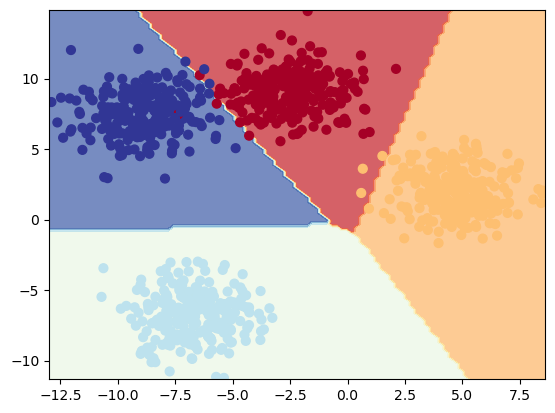

In [69]:
# visualize visualize visualize

plot_decision_boundary(model_4, X_blob, y_blob)

Looks like our model is doing pretty great. we can see that the groups are divided correctly here.

### 8.5. making and evaluating predictions with a PyTorch multi-class model

In [70]:
# make predictions
model_4.eval()
with torch.inference_mode():
    y_test_logits = model_4(X_blob_test)

# view first 10 predictions
y_test_logits[:10]

tensor([[ 0.6728,  2.8048, -5.8948, -3.6846],
        [ 3.1247, -4.3091,  1.2266,  4.8820],
        [-0.3193, -3.6616,  8.5252,  4.9316],
        [ 0.1084,  2.1751, -3.3363, -2.7251],
        [ 2.6332,  0.2090, -5.9259, -0.8331],
        [ 3.6064, -5.2834,  1.8419,  6.0177],
        [-0.7624, -2.6307,  7.7098,  3.7128],
        [ 2.6994, -0.9662, -3.9135,  0.6692],
        [ 0.2015, -5.3148, 10.3011,  6.9350],
        [ 2.6329, -0.5243, -4.5675,  0.1151]])

In [71]:
# go from logits -> predicts probabilities
y_pred_proba = torch.softmax(y_test_logits, dim=1)
y_pred_proba[:10]

tensor([[1.0586e-01, 8.9263e-01, 1.4875e-04, 1.3563e-03],
        [1.4394e-01, 8.5058e-05, 2.1569e-02, 8.3441e-01],
        [1.4030e-04, 4.9603e-06, 9.7309e-01, 2.6761e-02],
        [1.1124e-01, 8.7866e-01, 3.5504e-03, 6.5423e-03],
        [8.9288e-01, 7.9059e-02, 1.7125e-04, 2.7885e-02],
        [8.1168e-02, 1.1184e-05, 1.3902e-02, 9.0492e-01],
        [2.0539e-04, 3.1708e-05, 9.8173e-01, 1.8035e-02],
        [8.6338e-01, 2.2093e-02, 1.1594e-03, 1.1337e-01],
        [3.9722e-05, 1.5973e-07, 9.6659e-01, 3.3371e-02],
        [8.8974e-01, 3.7851e-02, 6.6399e-04, 7.1742e-02]])

In [72]:
# pred proba to pred labels
y_test_preds = torch.argmax(y_pred_proba, dim=1)
y_test_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [73]:
# let's check the real value
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

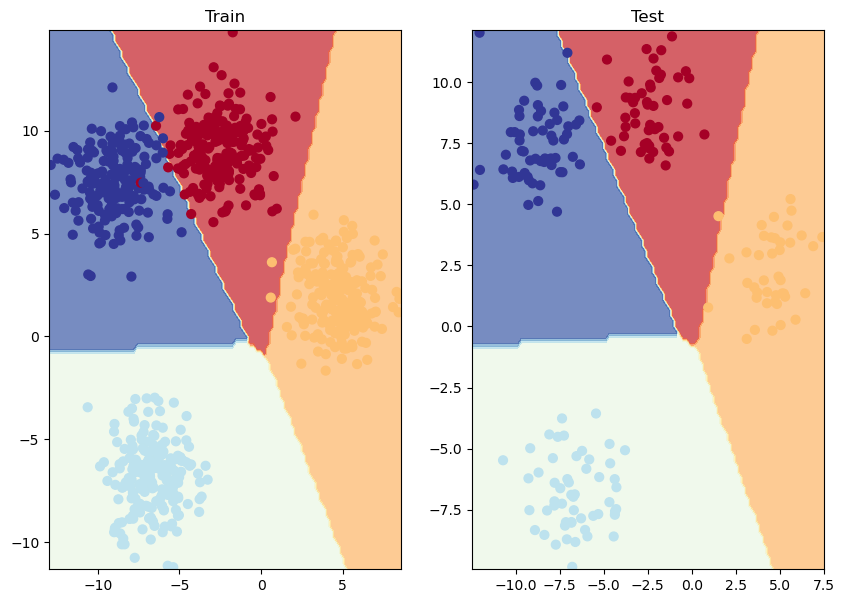

In [74]:
# lets visualize how our model did in train and test data

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

🎉 **Congratulations!!!**

Now lets look at classificaiton metrics

#### 9. A few ore classification metrics.. to evaluate our classification model

1. Accuracy
2. Precision
3. Recall
4. F1 Score
5. Confusion Matrix - puts together all the metrics we talked about
6. Classificaiton Report

Read this article to when to use Precision and when to use Recall:

[Beyond Accuracy: Precision And Recall](https://willkoehrsen.github.io/statistics/learning/beyond-accuracy-precision-and-recall/)

If you want a access to ta lot of PyTorch metrics, see TorchMetrics - https://lightning.ai/docs/torchmetrics/stable/

In [79]:
from torchmetrics import Accuracy

In [86]:
# setup metric
torchmetric_accuracy = Accuracy(task='MULTICLASS', num_classes=4)

# Calculate accuracy
torchmetric_accuracy(y_test_preds, y_blob_test)

tensor(0.9900)